# Section 1: MLP Model Implementation & Experiment Tracking

##  Implement a Multi-Layer Perceptron (MLP) Using the Iris Dataset

In [1]:
# !pip install wandb
# !pip install seaborn

In [2]:
# !pip install distutils

# # restart the kernal now for py3.13

# Import Libaray

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import wandb



# Setting up Dataset

In [4]:
# Load dataset
iris = load_iris()
X = iris.data
y = iris.target.reshape(-1, 1)  # Reshape for one-hot encoding

# # Shuffle data
# from sklearn.utils import shuffle
# X, y = shuffle(X, y, random_state=42)

# One-hot encoding
ohe = OneHotEncoder(sparse_output=False)
y_onehot = ohe.fit_transform(y)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_onehot, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_onehot, test_size=0.1, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)



# Setting up Model

In [5]:
# Define MLP model class
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_units, output_size):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_units)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_units, output_size)
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        """Here we are not the softmax function as the activation function for the output layer.
          beacsue we are using the cross entropy loss function which already has the softmax function implemented in it"""
        return x

# Instantiate the model, loss function, and optimizer
model = MLPModel(input_size=4, hidden_units=16, output_size=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Setting up W&B

In [6]:

import wandb

# Initialize Weights & Biases
wandb.init(project="MLP-Classification", name="MLP-Training-Run")

# Define hyperparameters
config = {
    "input_size": 4,
    "hidden_units": 16,
    "output_size": 3,
    "weight_init": "xavier",
    "bias_init": "zeros",
    "activation": "ReLU",
    "loss_function": "CrossEntropyLoss",
    "optimizer": "Adam",
    "learning_rate": 0.001,
    "batch_size": 32,
    "epochs": 50
}

# Log hyperparameters to W&B
wandb.config.update(config)

# Watch model for gradient tracking
wandb.watch(model, log="all")


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: parthivrpatel2005 (parthivrpatel2005-indian-institute-of-technology-gandhinagar) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


# Training The Model

In [7]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Define DataLoader for batching
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(X_test, y_test)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Updated Training Function
def train_model(model, train_loader, val_loader, epochs=50):
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, torch.max(y_batch, 1)[1])
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()  # Summing batch losses
        
        train_losses.append(total_train_loss)

        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                val_outputs = model(X_batch)
                val_loss = criterion(val_outputs, torch.max(y_batch, 1)[1])
                total_val_loss += val_loss.item()  # Summing batch losses
        
        val_losses.append(total_val_loss)
        
        # Log losses
        wandb.log({"train_loss": total_train_loss, "val_loss": total_val_loss})
        print(f"Epoch {epoch+1}: train_loss={total_train_loss:.4f}, val_loss={total_val_loss:.4f}")
    
    return train_losses, val_losses

# Train model
train_losses, val_losses = train_model(model, train_loader, val_loader, epochs=50)


Epoch 1: train_loss=5.6155, val_loss=1.1181
Epoch 2: train_loss=5.5319, val_loss=1.0990
Epoch 3: train_loss=5.5968, val_loss=1.0804
Epoch 4: train_loss=5.3565, val_loss=1.0622
Epoch 5: train_loss=5.2953, val_loss=1.0438
Epoch 6: train_loss=5.1395, val_loss=1.0254
Epoch 7: train_loss=5.0556, val_loss=1.0068
Epoch 8: train_loss=4.9874, val_loss=0.9878
Epoch 9: train_loss=4.9235, val_loss=0.9687
Epoch 10: train_loss=4.9343, val_loss=0.9493
Epoch 11: train_loss=4.7008, val_loss=0.9298
Epoch 12: train_loss=4.5695, val_loss=0.9099
Epoch 13: train_loss=4.5698, val_loss=0.8898
Epoch 14: train_loss=4.4378, val_loss=0.8691
Epoch 15: train_loss=4.2746, val_loss=0.8475
Epoch 16: train_loss=4.1899, val_loss=0.8252
Epoch 17: train_loss=4.2904, val_loss=0.8029
Epoch 18: train_loss=4.1664, val_loss=0.7809
Epoch 19: train_loss=3.8193, val_loss=0.7593
Epoch 20: train_loss=3.8905, val_loss=0.7374
Epoch 21: train_loss=3.6385, val_loss=0.7159
Epoch 22: train_loss=3.6663, val_loss=0.6950
Epoch 23: train_los

# Evaluation of Model

Training complete. Metrics logged to W&B.


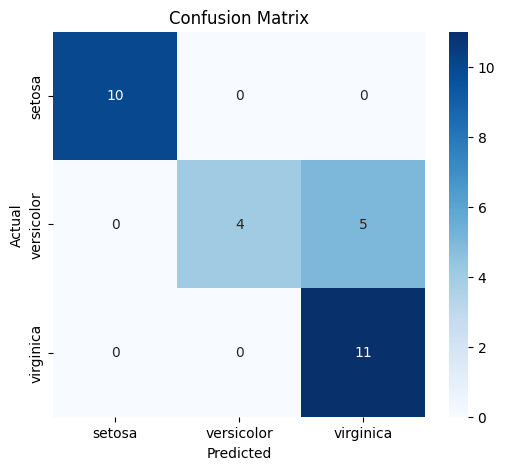

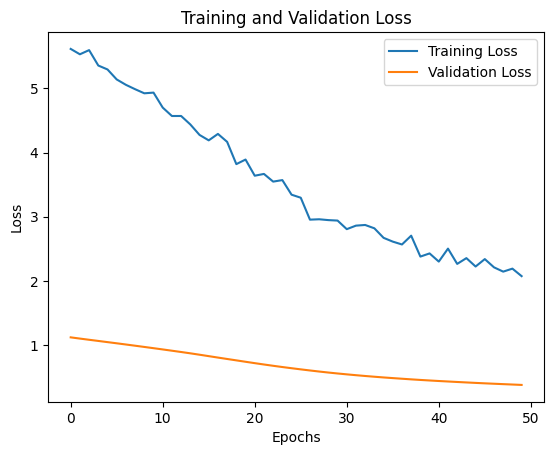

In [8]:

# Evaluate model
def evaluate_model(model, X_test, y_test):
    with torch.no_grad():
        y_pred = model(X_test)
        y_pred_classes = torch.argmax(y_pred, axis=1).numpy()
        y_true_classes = torch.argmax(y_test, axis=1).numpy()
    
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
    
    return accuracy, precision, recall, f1, y_true_classes, y_pred_classes

accuracy, precision, recall, f1, y_true_classes, y_pred_classes = evaluate_model(model, X_test, y_test)

# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")


# Plot training history
plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label="Validation Loss")
# plot val losses along with red marker

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.savefig("loss_curve.png")

# Log metrics to W&B
wandb.log({
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1_score": f1,
    "loss_curve": wandb.Image("loss_curve.png"),
    "confusion_matrix": wandb.Image("confusion_matrix.png")
})


print("Training complete. Metrics logged to W&B.")

In [9]:
print(accuracy, precision, recall, f1,)

0.8333333333333334 0.8854166666666666 0.8333333333333334 0.8167141500474834
